# What happens to the correlations over time?


## First, for the median case


In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from tqdm.notebook import tqdm

In [2]:
# !module load texlive
# !which latex
# import matplotlib.pyplot as plt
# import os

# os.environ['PATH'] = "/software/texlive/2020/bin/x86_64-linux:" + os.environ['PATH']

matplotlib.rcParams['text.usetex'] = False
matplotlib.rcParams['axes.labelsize'] = 24
matplotlib.rcParams['legend.fontsize'] = 20
matplotlib.rcParams['axes.titlesize'] = 24
matplotlib.rcParams['xtick.labelsize'] = 16
matplotlib.rcParams['ytick.labelsize'] = 16

In [3]:
def plot_correlations(population, time):
    df = population[population['sampling_time'] == time].reset_index(drop=True)
    rep1 = df[df['replicate'] == 0].reset_index(drop=True)
    rep2 = df[df['replicate'] == 1].reset_index(drop=True)
    rep2_rand = rep2.sample(frac=1, random_state=0, ignore_index=True)
    
    #Plot 2 scatter plots as subplots 
    fig, axs = plt.subplots(1, 3, figsize=(12, 6))
    plt.suptitle(f'Correlation at {time} minutes', fontsize=16)
    x = 'total_TF_mRNA'
    y = 'total_Target_mRNA'
    axs[0].scatter(df[x], df[y], alpha=0.5)
    axs[0].set_xlabel(x)
    axs[0].set_ylabel(y)
    axs[0].set_title(f'Correlation at {time} hours')
    axs[0].text(0.05, 0.95, f'$r = {spearmanr(df[x], df[y])[0]:.2e}$', transform=axs[0].transAxes, fontsize=12, verticalalignment='top')

    axs[1].scatter(np.log2(rep1[x] + 1) - np.log2( 1 + rep2[x]), np.log2(1+rep1[y]) - np.log2(1+rep2[y]), alpha=0.5)
    axs[1].set_xlabel(f'$\Delta {x}$')
    axs[1].set_ylabel(f'$\Delta {y}$')
    axs[1].set_title('Twin Pair Correlation')
    axs[1].text(0.05, 0.95, f'$r = {spearmanr(np.log2(rep1[x] + 1) - np.log2( 1 + rep2[x]),np.log2(1+rep1[y]) - np.log2(1+rep2[y]))[0]:.2e}$', transform=axs[1].transAxes, fontsize=12, verticalalignment='top')

    # axs[2].scatter(rep1[x] - rep2_rand[x], rep1[y] - rep2_rand[y], alpha=0.5)
    axs[2].scatter(np.log2(rep1[x] + 1) - np.log2( 1 + rep2_rand[x]), np.log2(1+rep1[y]) - np.log2(1+rep2_rand[y]), alpha=0.5)
    axs[2].set_xlabel(f'$\Delta {x}$ (randomized)')
    axs[2].set_ylabel(f'$\Delta {y}$ (randomized)')
    axs[2].set_title('Random Pair Correlation')
    axs[2].text(0.05, 0.95, f'$r = {spearmanr(np.log2(rep1[x] + 1) - np.log2( 1 + rep2_rand[x]), np.log2(1+rep1[y]) - np.log2(1+rep2_rand[y]))[0]:.2e}$', transform=axs[2].transAxes, fontsize=12, verticalalignment='top')
    plt.tight_layout()
    plt.show()

In [4]:
# Helper function for correlation
def compute_diff_correlation(rep1, rep2):
    diff_tf = rep1['total_TF_mRNA'] - rep2['total_TF_mRNA']
    diff_target = rep1['total_Target_mRNA'] - rep2['total_Target_mRNA']
    return spearmanr(diff_tf, diff_target)[0]

# Compute correlations at a time point
# def get_correlations(df, time):
#     df = df[df['sampling_time'] == time].reset_index(drop=True)
#     corr_gene_gene = spearmanr(df['total_TF_mRNA'], df['total_Target_mRNA'])[0]

#     rep1 = df[df['replicate'] == 0].reset_index(drop=True)
#     rep2 = df[df['replicate'] == 1].reset_index(drop=True)

#     corr_twin_pair = compute_diff_correlation(rep1, rep2)
#     rep2_random = rep2.sample(frac=1, random_state=0, ignore_index=True)
#     corr_random_pair = compute_diff_correlation(rep1, rep2_random)

#     return corr_gene_gene, corr_twin_pair, corr_random_pair
def get_correlations(df, time):
    df = df[df['sampling_time'] == time].reset_index(drop=True)

    # Gene-gene correlation in the full population
    corr_gene_gene = spearmanr(df['total_TF_mRNA'], df['total_Target_mRNA'])[0]

    # Extract replicates
    rep1 = df[df['replicate'] == 0].reset_index(drop=True)
    rep2 = df[df['replicate'] == 1].reset_index(drop=True)

    # Match by cell index (assuming same order)
    if len(rep1) != len(rep2):
        min_len = min(len(rep1), len(rep2))
        rep1 = rep1.iloc[:min_len].reset_index(drop=True)
        rep2 = rep2.iloc[:min_len].reset_index(drop=True)

    # Filter out undivided cells: keep only where *any* state variable is non-zero
    state_vars = [col for col in df.columns if col not in ['replicate', 'sampling_time', 'cell_index', 'replicate_index']]
    state_vars = [col for col in state_vars if not col.startswith("total_") and not col.endswith("_protein")]

    # Check for division in either replicate
    divided_mask = (rep1[state_vars].abs().sum(axis=1) > 0) | (rep2[state_vars].abs().sum(axis=1) > 0)
    rep1 = rep1[divided_mask].reset_index(drop=True)
    rep2 = rep2[divided_mask].reset_index(drop=True)

    if len(rep1) < 2:
        # Not enough valid twins to compute correlation
        return np.nan, np.nan, np.nan

    # Compute delta correlation on valid twins
    corr_twin_pair = compute_diff_correlation(rep1, rep2)

    # Random shuffle of rep2
    rep2_random = rep2.sample(frac=1, random_state=0, ignore_index=True)
    corr_random_pair = compute_diff_correlation(rep1, rep2_random)

    return corr_gene_gene, corr_twin_pair, corr_random_pair


# Parallelized task per simulation
def process_simulation_single_population(sim, path_to_folder, time_points, run = 0):
    sim_path = os.path.join(path_to_folder, sim)
    population = pd.read_csv(sim_path)

    corr_dict_list = []
    for time in tqdm(time_points):
        gene_gene_corr, twin_pair_corr, random_pair_corr = get_correlations(population, time)
        #Plotting the correlations
        # plot_correlations(population, time)
        corr_dict_row = {
            'time_point': time,
            'gene_gene_correlation': gene_gene_corr,
            'twin_pair_correlation': twin_pair_corr,
            'random_pair_correlation': random_pair_corr,
            'run': run
        }
        corr_dict_list.append(corr_dict_row)
    
    corr_dict_df = pd.DataFrame(corr_dict_list)
    return corr_dict_df


In [39]:
corr_list = []
# Calculate correlation between target and tf over time
for run in np.arange(0,10,1):
    population = pd.read_csv(f'/home/mzo5929/Keerthana/grnInference/simulationData/simulations_reruns/median_quartile_params/samples_replicates_over_time_with_regulation_default_{run}.csv')
    # population_1 = pd.read_csv(f'/home/mzo5929/Keerthana/grnInference/simulationData/simulations_reruns/median_quartile_params/samples_replicates_over_time_with_regulation_lower_quartile_{run}.csv')
    # population_2 = pd.read_csv(f'/home/mzo5929/Keerthana/grnInference/simulationData/simulations_reruns/median_quartile_params/samples_replicates_over_time_with_regulation_upper_quartile_{run}.csv')
    # population_1 = pd.read_csv(f'/home/mzo5929/Keerthana/grnInference/simulationData/simulations_reruns/median_params_no_regulation/samples_replicates_over_time_with_regulation_lower_quartile_{run}.csv')
    # population_2 = pd.read_csv(f'/home/mzo5929/Keerthana/grnInference/simulationData/simulations_reruns/median_params_no_regulation/samples_replicates_over_time_with_regulation_upper_quartile_{run}.csv')
    # population = pd.concat([population_1, population_2], ignore_index=True)
    time_points = population['sampling_time'].unique()
    df_0 = population[population['sampling_time'] == 0].reset_index(drop=True)
    
    for time in tqdm(time_points):
        df = population[population['sampling_time'] == time].reset_index(drop=True)
        correlation = spearmanr(df_0['total_TF_mRNA'], df['total_Target_mRNA'])
        gene_gene_corr, twin_pair_corr, random_pair_corr = get_correlations(population, time)
        corr_dict = {
            'run': run,
            'time_point': time,
            'correlation': correlation[0],
            'gene_gene_correlation': gene_gene_corr,
            'twin_pair_correlation': twin_pair_corr,
            'random_pair_correlation': random_pair_corr
        }
        corr_list.append(corr_dict)

corr_df_list = pd.DataFrame(corr_list)
# corr_df_list_mixed = pd.DataFrame(corr_list)
# corr_df_list_mixed_no_reg = pd.DataFrame(corr_list)



  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

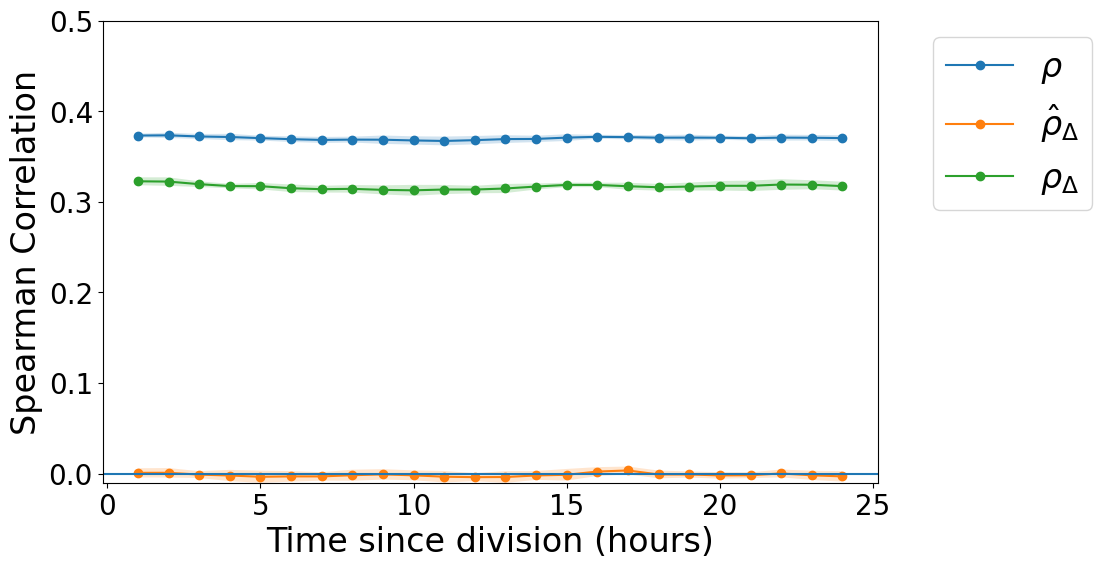

In [29]:
corr_df = corr_df_list_mixed_no_reg.groupby(['time_point']).agg({
    'correlation': ['mean', 'std'],
    'gene_gene_correlation': ['mean', 'std'],
    'twin_pair_correlation': ['mean', 'std'],
    'random_pair_correlation': ['mean', 'std']
}).reset_index()

#Plot the correlation over time
plt.figure(figsize=(10, 6))
# plt.plot(corr_df['time_point'][1:]/60, corr_df['correlation']['mean'], label='Gene-Gene across time')
# plt.fill_between(corr_df['time_point'][1:]/60, corr_df['correlation']['mean'] - corr_df['correlation']['std'], corr_df['correlation']['mean'] + corr_df['correlation']['std'], alpha=0.2)
plt.plot(corr_df['time_point'][1:]/60, corr_df['gene_gene_correlation']['mean'][1:],  label=r'$\rho$', marker='o')
plt.fill_between(corr_df['time_point'][1:]/60, corr_df['gene_gene_correlation']['mean'][1:] - corr_df['gene_gene_correlation']['std'][1:], corr_df['gene_gene_correlation']['mean'][1:] + corr_df['gene_gene_correlation']['std'][1:], alpha=0.2)
plt.plot(corr_df['time_point'][1:]/60, corr_df['twin_pair_correlation']['mean'][1:], label=r'$\hat{\rho}_{\Delta}$', marker='o')
plt.fill_between(corr_df['time_point'][1:]/60, corr_df['twin_pair_correlation']['mean'][1:] - corr_df['twin_pair_correlation']['std'][1:], corr_df['twin_pair_correlation']['mean'][1:] + corr_df['twin_pair_correlation']['std'][1:], alpha=0.2)
plt.plot(corr_df['time_point'][1:]/60, corr_df['random_pair_correlation']['mean'][1:], label=r'$\rho_{\Delta}$', marker='o')
plt.fill_between(corr_df['time_point'][1:]/60, corr_df['random_pair_correlation']['mean'][1:] - corr_df['random_pair_correlation']['std'][1:], corr_df['random_pair_correlation']['mean'][1:] + corr_df['random_pair_correlation']['std'][1:], alpha=0.2)
# plt.plot(corr_df['time_point'], corr_df['random_pair_correlation'], marker='o', label='Random Pair Correlation')
plt.xlabel('Time since division (hours)', fontsize=24)
plt.ylabel('Spearman Correlation', fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=24)
# plt.title('Correlation between TF and Target mRNA over Time')
# plt.axhline(0.001, color="black", linestyle='--', label='Threshold')
# plt.axhline(-0.001, color="black", linestyle='--')
plt.axhline(0)
plt.ylim(-0.01, 0.5)
# plt.ylim(-0.2, 0.2)
# plt.yscale('log')
# plt.xscale('log')
# plt.grid()
# plt.savefig("/home/mzo5929/Keerthana/grnInference/plots/two_state_reg/correlation_over_time_mixed_two_state_no_reg.png", bbox_inches='tight', dpi=300)
plt.show()

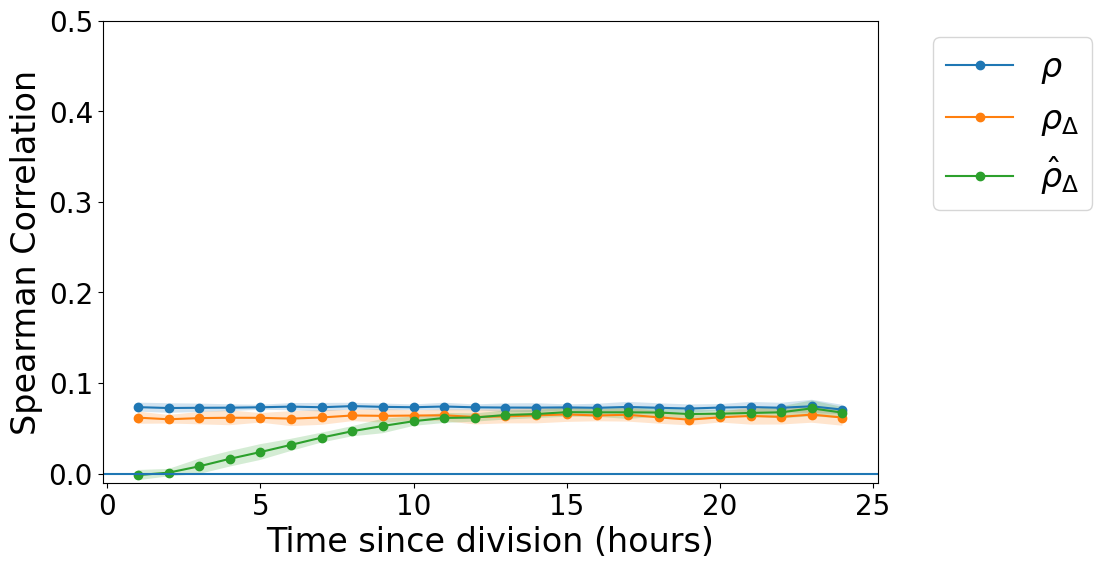

In [40]:
corr_df = corr_df_list.groupby(['time_point']).agg({
    'correlation': ['mean', 'std'],
    'gene_gene_correlation': ['mean', 'std'],
    'twin_pair_correlation': ['mean', 'std'],
    'random_pair_correlation': ['mean', 'std']
}).reset_index()
# Sample every 6th time point
corr_df = corr_df[corr_df['time_point'] % 60 == 0].reset_index(drop=True)
#Plot the correlation over time
plt.figure(figsize=(10, 6))
# plt.plot(corr_df['time_point'][1:]/60, corr_df['correlation']['mean'], label='Gene-Gene across time')
# plt.fill_between(corr_df['time_point'][1:]/60, corr_df['correlation']['mean'] - corr_df['correlation']['std'], corr_df['correlation']['mean'] + corr_df['correlation']['std'], alpha=0.2)
plt.plot(corr_df['time_point'][1:]/60, corr_df['gene_gene_correlation']['mean'][1:],  label=r'$\rho$', marker='o')
plt.fill_between(corr_df['time_point'][1:]/60, corr_df['gene_gene_correlation']['mean'][1:] - corr_df['gene_gene_correlation']['std'][1:], corr_df['gene_gene_correlation']['mean'][1:] + corr_df['gene_gene_correlation']['std'][1:], alpha=0.2)
plt.plot(corr_df['time_point'][1:]/60, corr_df['random_pair_correlation']['mean'][1:], label=r'$\rho_{\Delta}$', marker='o')
plt.fill_between(corr_df['time_point'][1:]/60, corr_df['random_pair_correlation']['mean'][1:] - corr_df['random_pair_correlation']['std'][1:], corr_df['random_pair_correlation']['mean'][1:] + corr_df['random_pair_correlation']['std'][1:], alpha=0.2)
plt.plot(corr_df['time_point'][1:]/60, corr_df['twin_pair_correlation']['mean'][1:], label=r'$\hat{\rho}_{\Delta}$', marker='o')
plt.fill_between(corr_df['time_point'][1:]/60, corr_df['twin_pair_correlation']['mean'][1:] - corr_df['twin_pair_correlation']['std'][1:], corr_df['twin_pair_correlation']['mean'][1:] + corr_df['twin_pair_correlation']['std'][1:], alpha=0.2)
# plt.plot(corr_df['time_point'], corr_df['random_pair_correlation'], marker='o', label='Random Pair Correlation')
plt.xlabel('Time since division (hours)', fontsize=24)
plt.ylabel('Spearman Correlation', fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=24)
# plt.title('Correlation between TF and Target mRNA over Time')
# plt.axhline(0.001, color="black", linestyle='--', label='Threshold')
# plt.axhline(-0.001, color="black", linestyle='--')
plt.axhline(0)
plt.ylim(-0.01, 0.5)
# plt.ylim(-0.2, 0.2)
# plt.yscale('log')
# plt.xscale('log')
# plt.grid()
# plt.savefig("/home/mzo5929/Keerthana/grnInference/plots/two_state_reg/correlation_over_time_mixed_one_state.png", bbox_inches='tight', dpi=300)
plt.show()

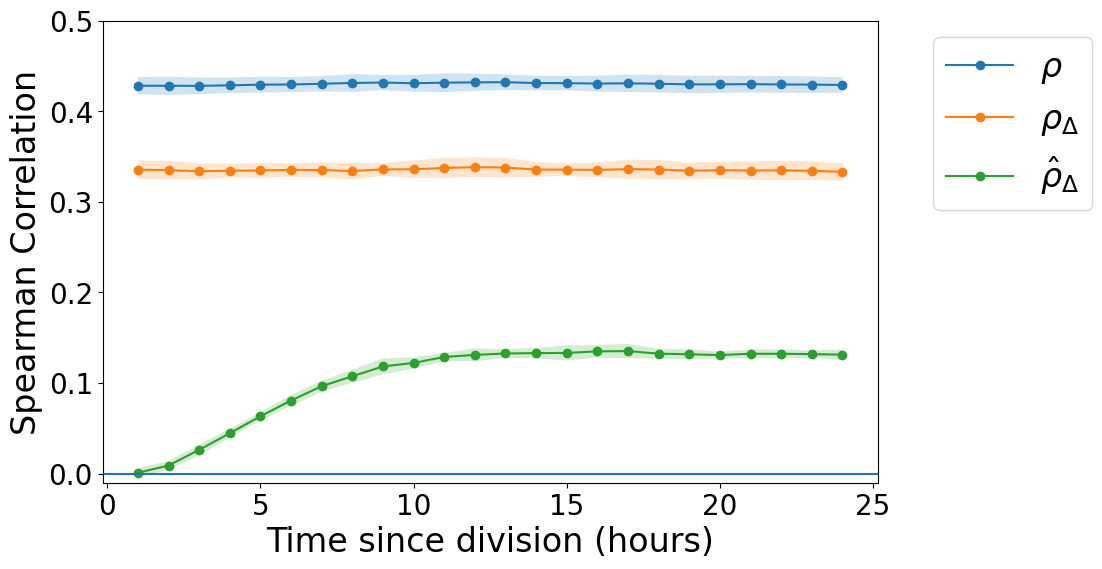

In [41]:
corr_df = corr_df_list_mixed.groupby(['time_point']).agg({
    'correlation': ['mean', 'std'],
    'gene_gene_correlation': ['mean', 'std'],
    'twin_pair_correlation': ['mean', 'std'],
    'random_pair_correlation': ['mean', 'std']
}).reset_index()

#Plot the correlation over time
plt.figure(figsize=(10, 6))
# plt.plot(corr_df['time_point'][1:]/60, corr_df['correlation']['mean'], label='Gene-Gene across time')
# plt.fill_between(corr_df['time_point'][1:]/60, corr_df['correlation']['mean'] - corr_df['correlation']['std'], corr_df['correlation']['mean'] + corr_df['correlation']['std'], alpha=0.2)
plt.plot(corr_df['time_point'][1:]/60, corr_df['gene_gene_correlation']['mean'][1:],  label=r'$\rho$', marker='o')
plt.fill_between(corr_df['time_point'][1:]/60, corr_df['gene_gene_correlation']['mean'][1:] - corr_df['gene_gene_correlation']['std'][1:], corr_df['gene_gene_correlation']['mean'][1:] + corr_df['gene_gene_correlation']['std'][1:], alpha=0.2)
plt.plot(corr_df['time_point'][1:]/60, corr_df['random_pair_correlation']['mean'][1:], label=r'$\rho_{\Delta}$', marker='o')
plt.fill_between(corr_df['time_point'][1:]/60, corr_df['random_pair_correlation']['mean'][1:] - corr_df['random_pair_correlation']['std'][1:], corr_df['random_pair_correlation']['mean'][1:] + corr_df['random_pair_correlation']['std'][1:], alpha=0.2)
plt.plot(corr_df['time_point'][1:]/60, corr_df['twin_pair_correlation']['mean'][1:], label=r'$\hat{\rho}_{\Delta}$', marker='o')
plt.fill_between(corr_df['time_point'][1:]/60, corr_df['twin_pair_correlation']['mean'][1:] - corr_df['twin_pair_correlation']['std'][1:], corr_df['twin_pair_correlation']['mean'][1:] + corr_df['twin_pair_correlation']['std'][1:], alpha=0.2)
# plt.plot(corr_df['time_point'], corr_df['random_pair_correlation'], marker='o', label='Random Pair Correlation')
plt.xlabel('Time since division (hours)', fontsize=24)
plt.ylabel('Spearman Correlation', fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=24)
# plt.title('Correlation between TF and Target mRNA over Time')
# plt.axhline(0.001, color="black", linestyle='--', label='Threshold')
# plt.axhline(-0.001, color="black", linestyle='--')
plt.axhline(0)
plt.ylim(-0.01, 0.5)
# plt.ylim(-0.2, 0.2)
# plt.yscale('log')
# plt.xscale('log')
# plt.grid()
plt.savefig("/home/mzo5929/Keerthana/grnInference/plots/two_state_reg/correlation_over_time_mixed.png", bbox_inches='tight', dpi=300)
plt.show()

## Compare correlation between 2 separate runs


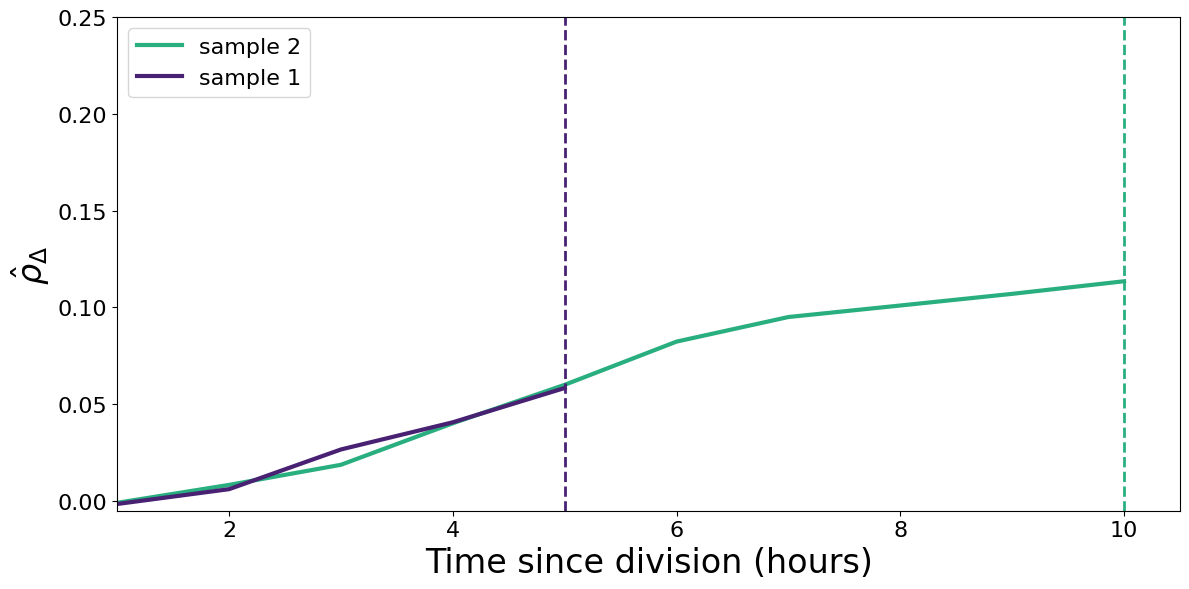

In [57]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Get unique runs and generate shades
runs = [0, 6]
base_cmap = plt.get_cmap('Blues_r', n_runs + 20)  # More shades, skip lightest
colors = [base_cmap(2*i + 10) for i in range(n_runs)]  # Avoid pale shades

# Create plot
plt.figure(figsize=(12, 6))
runs = [6, 0]
for idx, run in enumerate(runs):
    run_df = corr_df_list_mixed[corr_df_list_mixed['run'] == run]
    if run == 0:
        run_df = run_df[run_df['time_point'] <= 300]  # Skip time point 0 for the first run
        plt.plot(run_df['time_point'][1:] / 60, run_df['twin_pair_correlation'][1:],
                label=f'sample {1}', color="#482173", linewidth=3)
    else:
        run_df = run_df[run_df['time_point'] <=600]
        plt.plot(run_df['time_point'][1:] / 60, run_df['twin_pair_correlation'][1:],
                label=f'sample {2}', color="#29AF7F", linewidth=3)
plt.plot
# Labels and formatting
plt.xlabel('Time since division (hours)', fontsize=24)
plt.ylabel(r'$\hat{\rho}_{\Delta}$', fontsize=24)
# plt.axhline(0.001, color="black", linestyle='--')
# plt.axhline(-0.001, color="black", linestyle='--')
plt.axvline(5, color='#482173', linestyle='--', linewidth=2)
plt.axvline(10, color='#29AF7F', linestyle='--', linewidth=2)
plt.xlim(1,10.5)
plt.ylim(-0.005, 0.2)
plt.yticks(np.arange(0, 0.3, 0.05))  # Fixed step size
# plt.grid(True)

# Legend outside plot
plt.legend(loc='upper left', fontsize=16)
plt.tight_layout()
# plt.savefig("/home/mzo5929/Keerthana/grnInference/plots/two_state_reg/twin_pair_correlation_experiment.png", bbox_inches='tight', dpi=300)
plt.show()


## Compare correlation between the two timepoints for all simulations - does it hold up?


In [55]:
correlation_folder = "/home/mzo5929/Keerthana/grnInference/analysisData2/"
list_of_files = []
for file in os.listdir(correlation_folder):
    #Select all files which do not have "no_regulation" or "mixed" in the name
    if "no_reg" not in file and "mixed" not in file:
        if file.endswith(".csv"):
            file_path = os.path.join(correlation_folder, file)
            file_list = file.split('_')
            #Remove .csv and add the rest of the file name as a parameter
            param = '_'.join(file_list[1:])
            param = param.replace(".csv", "")
            list_of_files.append((file_path, param))


In [56]:
corr_data_across_param = []
for file, param in list_of_files:
    df = pd.read_csv(file)
    #Find the parameter column in the dataframe by making all column names lowercase
    print(param)
    param_col = [col for col in df.columns if param.lower() in col.lower()]
    for param_value in df[param_col[0]].unique():
        param_df = df[df[param_col[0]] == param_value].reset_index(drop=True)
        for run in param_df['run'].unique():
            param_value = param_value
            run_df = param_df[param_df['run'] == run]
            twin_corr_t1 = run_df['t1_twin_pair_correlation'].values[0]
            twin_corr_t2 = run_df['t2_twin_pair_correlation'].values[0]
            random_corr_t1 = run_df['t1_random_pair_correlation'].values[0]
            random_corr_t2 = run_df['t2_random_pair_correlation'].values[0]
            corr_dict = {
                'run': run.replace(".csv", ""),
                'param': param,
                'param_value': param_value,
                'twin_pair_correlation_t1': twin_corr_t1,
                'twin_pair_correlation_t2': twin_corr_t2,
                'random_pair_correlation_t1': random_corr_t1,
                'random_pair_correlation_t2': random_corr_t2
            }
            corr_data_across_param.append(corr_dict)

k_off_target
k_on_tf
burst_size_tf
mrna_half_life_tf
k_off_tf
burst_size_target
protein_half_life
k_on_target
mrna_half_life_target


In [57]:
corr_data_across_param = pd.DataFrame(corr_data_across_param)
corr_data_across_param

,run,param,param_value,twin_pair_correlation_t1,twin_pair_correlation_t2,random_pair_correlation_t1,random_pair_correlation_t2
0,9,k_off_target,62.517778,0.045217,0.074024,0.082377,0.076244
1,7,k_off_target,62.517778,0.036873,0.054642,0.085742,0.075156
2,1,k_off_target,62.517778,0.022147,0.061505,0.056737,0.066786
3,8,k_off_target,62.517778,0.018567,0.062102,0.064533,0.068422
4,6,k_off_target,62.517778,0.020667,0.057389,0.078053,0.065472
...,...,...,...,...,...,...,...
895,5,mrna_half_life_target,5.444444,0.007591,0.043133,0.037732,0.040084
896,6,mrna_half_life_target,5.444444,0.026382,0.050831,0.048301,0.055075
897,3,mrna_half_life_target,5.444444,0.015917,0.040075,0.071452,0.054245
898,7,mrna_half_life_target,5.444444,0.029084,0.045008,0.064784,0.048438


/tmp/ipykernel_1405800/837775430.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis', len(unique_params))  # discrete colors


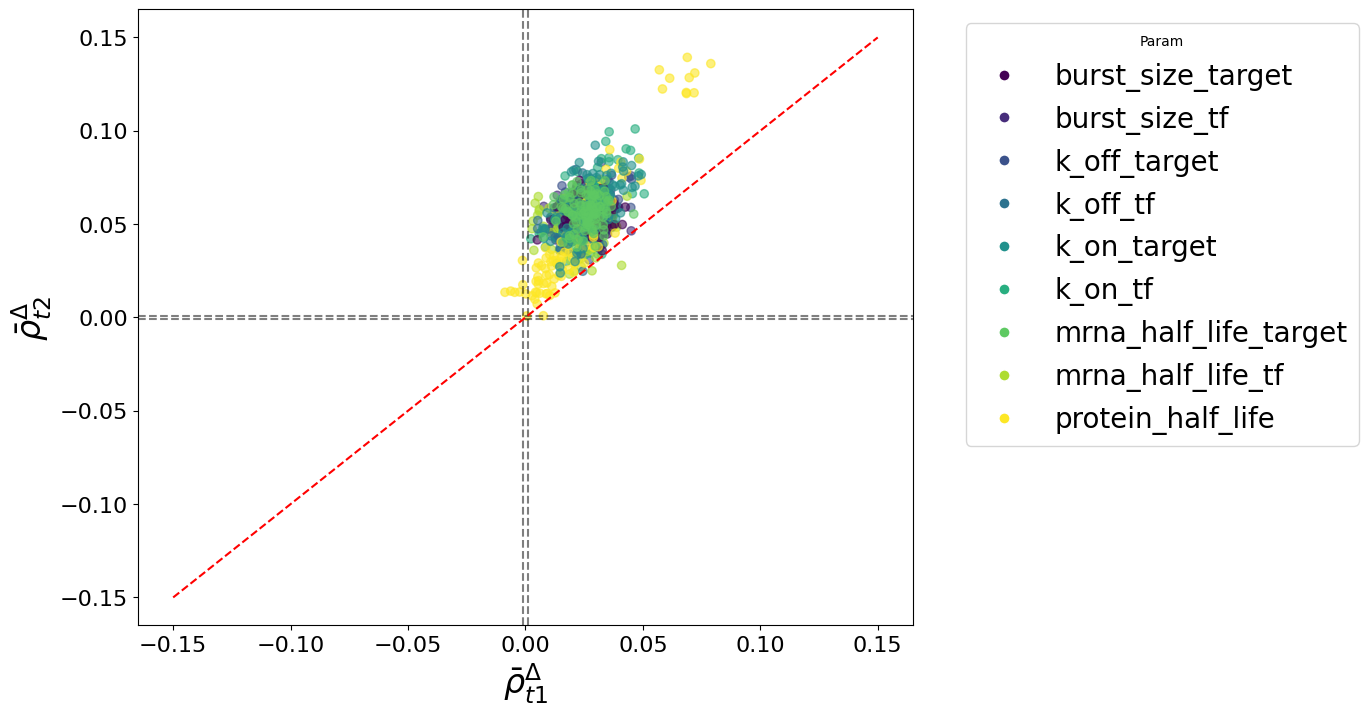

In [77]:
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib import cm
import numpy as np

# Step 1: Map string params to integers
unique_params = sorted(corr_data_across_param['param'].unique())
param_to_int = {p: i for i, p in enumerate(unique_params)}
param_values_numeric = corr_data_across_param['param'].map(param_to_int)

# Step 2: Define colormap
cmap = cm.get_cmap('viridis', len(unique_params))  # discrete colors
colors = cmap(param_values_numeric)

# Step 3: Create scatter plot
fig, ax = plt.subplots(figsize=(10, 8))
scatter = ax.scatter(
    corr_data_across_param['twin_pair_correlation_t1'],
    corr_data_across_param['twin_pair_correlation_t2'],
    c=param_values_numeric,
    cmap=cmap,
    alpha=0.6
)

# Labels and lines
ax.set_xlabel(r'$\bar{\rho}^\Delta_{t1}$')
ax.set_ylabel(r'$\bar{\rho}^\Delta_{t2}$')
ax.axvline(x=1e-3, color='black', linestyle='--', alpha=0.5)
ax.axvline(x=-1e-3, color='black', linestyle='--', alpha=0.5)
ax.axhline(y=1e-3, color='black', linestyle='--', alpha=0.5)
ax.axhline(y=-1e-3, color='black', linestyle='--', alpha=0.5)
ax.plot([-0.15, 0.15], [-0.15, 0.15], color='red', linestyle='--', label='y = x')

# Step 4: Custom legend for string parameters
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label=param,
           markerfacecolor=cmap(i), markersize=8)
    for i, param in enumerate(unique_params)
]
ax.legend(handles=legend_elements, title="Param", bbox_to_anchor=(1.05, 1), loc='upper left')

# plt.tight_layout()
plt.show()


In [ ]:
#For each parameter, plot the value for t1 for a run vs value for t2 for different runs
for param in unique_params:
    param_df = corr_data_across_param[corr_data_across_param['param'] == param]
    for param_value in param_df['param_value'].unique():
        param_df_value = param_df[param_df['param_value'] == param_value].reset_index(drop=True)
        
        plt.figure(figsize=(10, 6))
        run = 0

        plt.scatter(param_df['twin_pair_correlation_t1'], param_df['twin_pair_correlation_t2'], c=param_values_numeric[param_df.index], cmap=cmap, alpha=0.6)
        plt.xlabel(r'$\bar{\rho}^\Delta_{t1}$')
        plt.ylabel(r'$\bar{\rho}^\Delta_{t2}$')
        plt.title(f'Twin Pair Correlation for {param}')
        plt.axvline(x=1e-3, color='black', linestyle='--', alpha=0.5)
        plt.axvline(x=-1e-3, color='black', linestyle='--', alpha=0.5)
        plt.axhline(y=1e-3, color='black', linestyle='--', alpha=0.5)
        plt.axhline(y=-1e-3, color='black', linestyle='--', alpha=0.5)
        plt.plot([-0.15, 0.15], [-0.15, 0.15], color='red', linestyle='--', label='y = x')
        plt.colorbar(label='Parameter Value')
        plt.legend()
        plt.show()

## scatter plot for all timepoints


In [6]:
#Get time based correlation for median parameters - 
path_to_folder = "/home/mzo5929/Keerthana/grnInference/simulationData/asynchronous_division/actual_variation/"
correlation_df_all_sigma = []
for i in np.arange(0, 10, 1):  
    sim = f"samples_replicates_with_regulation_{i}.csv"
    time_points = np.arange(0, 2881, 60 )
    correlation_df = process_simulation_single_population(sim, path_to_folder, time_points)
    correlation_df["sigma"] = 0.001 * (i + 1)
    correlation_df_all_sigma.append(correlation_df)
# sim_sync = pd.read_csv("/home/mzo5929/Keerthana/grnInference/simulationData/simulations_rerun/with_regulation/median/samples_replicates_with_regulation_median_0.csv")
path_to_folder_sync = "/home/mzo5929/Keerthana/grnInference/simulationData/simulations_rerun/with_regulation/median/"
time_points_sync = np.arange(0, 1441, 60 )
correlation_df = process_simulation_single_population("samples_replicates_with_regulation_median_0.csv", path_to_folder_sync, time_points, run=10)
correlation_df['time_point'] = correlation_df['time_point'] + 0.8*60  # Adjust time point to match the asynchronous data
correlation_df['sigma'] = 0
# Concatenate all runs into a single DataFrame
# correlation_df_all_runs = pd.concat(correlation_df_all_runs, ignore_index=True)
correlation_df_all_sigma.append(correlation_df)
# Concatenate all sigma runs into a single DataFrame
correlation_df_all_sigma = pd.concat(correlation_df_all_sigma, ignore_index=True)

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

In [8]:
correlation_df

,time_point,gene_gene_correlation,twin_pair_correlation,random_pair_correlation,run,sigma
0,48.0,0.064453,0.008556,0.046861,10,0
1,108.0,0.067634,-0.008798,0.057999,10,0
2,168.0,0.067081,0.008399,0.057729,10,0
3,228.0,0.066891,0.011652,0.056215,10,0
4,288.0,0.073555,0.013189,0.059031,10,0
5,348.0,0.074665,0.027204,0.064439,10,0
6,408.0,0.071914,0.034135,0.066271,10,0
7,468.0,0.071620,0.042413,0.068259,10,0
8,528.0,0.073654,0.045670,0.074998,10,0
9,588.0,0.076127,0.057569,0.070542,10,0


/tmp/ipykernel_716168/539395711.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sigma_df['adjusted_time'] = sigma_df['time_point']/60 - 0.8*24
/tmp/ipykernel_716168/539395711.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sigma_df['adjusted_time'] = sigma_df['time_point']/60 - 0.8*24
/tmp/ipykernel_716168/539395711.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

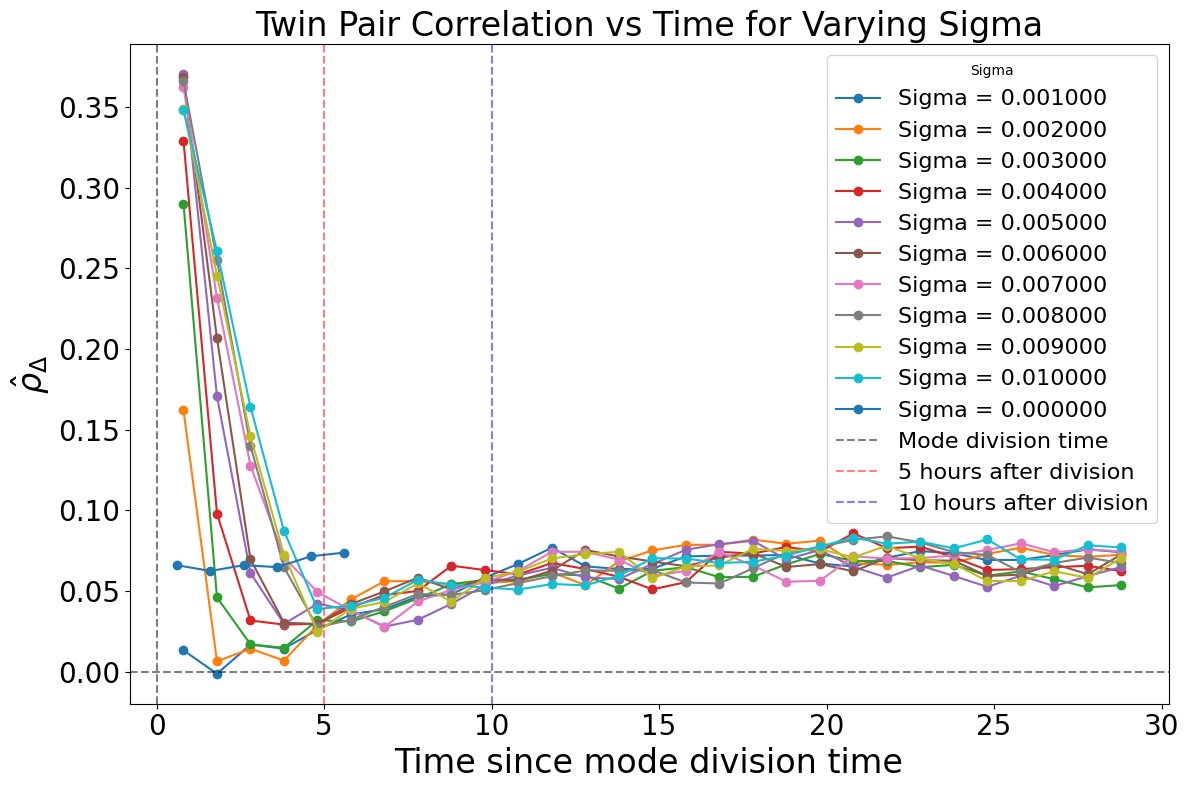

In [7]:

#Plot correlation vs time for each sigma value
plt.figure(figsize=(12, 8))
for sigma in correlation_df_all_sigma['sigma'].unique():
    sigma_df = correlation_df_all_sigma[correlation_df_all_sigma['sigma'] == sigma]
    sigma_df['adjusted_time'] = sigma_df['time_point']/60 - 0.8*24
    sigma_df = sigma_df[sigma_df['adjusted_time'] >= 0]  # Filter out negative times
    plt.plot(sigma_df['time_point']/60 - 0.8*24, sigma_df['twin_pair_correlation'], label=f'Sigma = {sigma:3f}', marker='o')
plt.xlabel('Time since mode division time', fontsize=24)
plt.ylabel(r'$\hat{\rho}_{\Delta}$', fontsize=24)
plt.axvline(0, color='black', linestyle='--', alpha=0.5, label='Mode division time')
plt.axvline(5, color='red', linestyle='--', alpha=0.5, label='5 hours after division')
plt.axvline(10, color='blue', linestyle='--', alpha=0.5, label='10 hours after division')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.axhline(0, color='black', linestyle='--', alpha=0.5)
plt.legend(title='Sigma', fontsize=16)
plt.title('Twin Pair Correlation vs Time for Varying Sigma', fontsize=24)
plt.tight_layout()
plt.show()

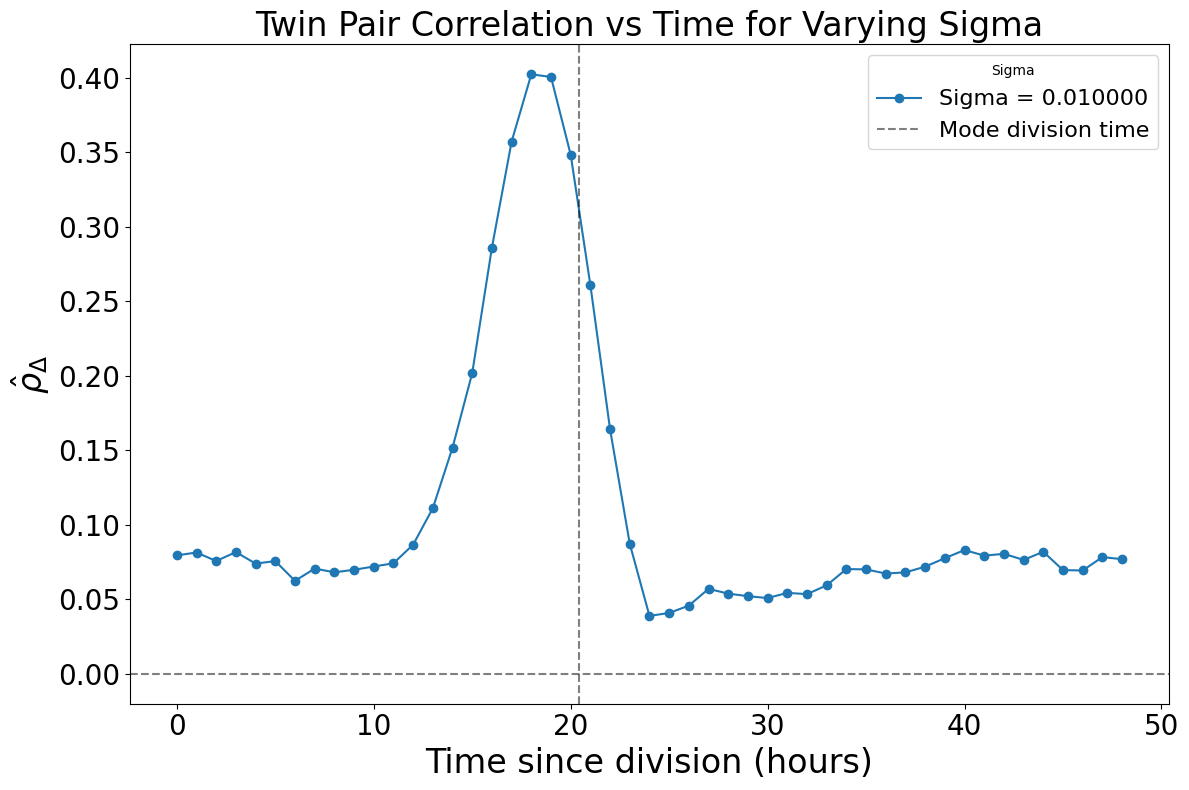

In [28]:
#Plot correlation vs time for each sigma value
plt.figure(figsize=(12, 8))
sigma_df = correlation_df_all_sigma[correlation_df_all_sigma['sigma'] == 0.01]
plt.plot(sigma_df['time_point']/60, sigma_df['twin_pair_correlation'], label=f'Sigma = {sigma:3f}', marker='o')
plt.xlabel('Time since division (hours)', fontsize=24)
plt.ylabel(r'$\hat{\rho}_{\Delta}$', fontsize=24)
plt.axvline(0.85*24, color='black', linestyle='--', alpha=0.5, label='Mode division time')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.axhline(0, color='black', linestyle='--', alpha=0.5)
plt.legend(title='Sigma', fontsize=16)
plt.title('Twin Pair Correlation vs Time for Varying Sigma', fontsize=24)
plt.tight_layout()
plt.show()

## Directionality


In [ ]:
positive_control_corr = []
negative_control_corr = []
twin_1_corr = []
twin_2_corr = []
twin_1_rev_corr = []
twin_2_rev_corr = []
random_1_corr = []
random_2_corr = []
random_1_rev_corr = []
random_2_rev_corr = []

from tqdm.notebook import tqdm

# Get time based correlation for median parameters
path_to_folder = "/home/mzo5929/Keerthana/grnInference/simulationData/simulations_rerun/with_regulation/median/"
for run in tqdm(np.arange(0, 24)):
    path_to_file = f"{path_to_folder}/samples_replicates_with_regulation_median_{int(run)}.csv"
    sim_file = pd.read_csv(path_to_file)
    t1_sim_file = sim_file[sim_file['sampling_time'] ==600].reset_index(drop=True)
    t1_rep0 = t1_sim_file[t1_sim_file['replicate'] == 0].reset_index(drop=True)
    t1_rep1 = t1_sim_file[t1_sim_file['replicate'] == 1].reset_index(drop=True)
    random_rep_0_t1 = t1_rep0.sample(frac=1, random_state=0, ignore_index=True)
    random_rep_1_t1 = t1_rep1.sample(frac=1, random_state=0, ignore_index=True)
    
    
    t2_sim_file = sim_file[sim_file['sampling_time'] == 900].reset_index(drop=True)
    t2_rep0 = t2_sim_file[t2_sim_file['replicate'] == 0].reset_index(drop=True)
    t2_rep1 = t2_sim_file[t2_sim_file['replicate'] == 1].reset_index(drop=True)
    random_rep_0_t2 = t2_rep0.sample(frac=1, random_state=20, ignore_index=True)
    random_rep_1_t2 = t2_rep1.sample(frac=1, random_state=40, ignore_index=True)

    twin_1_corr.append(spearmanr(t1_rep0['total_TF_mRNA'], t2_rep1['total_Target_mRNA'])[0])
    random_1_corr.append(spearmanr(random_rep_0_t1['total_TF_mRNA'], random_rep_1_t2['total_Target_mRNA'])[0])
    twin_1_rev_corr.append(spearmanr(t1_rep0['total_Target_mRNA'], t2_rep1['total_TF_mRNA'])[0])
    random_1_rev_corr.append(spearmanr(random_rep_0_t1['total_Target_mRNA'], random_rep_1_t2['total_TF_mRNA'])[0])
    
    twin_2_corr.append(spearmanr(t1_rep1['total_TF_mRNA'], t2_rep0['total_Target_mRNA'])[0])
    random_2_corr.append(spearmanr(random_rep_1_t1['total_TF_mRNA'], random_rep_0_t2['total_Target_mRNA'])[0])
    twin_2_rev_corr.append(spearmanr(t1_rep1['total_Target_mRNA'], t2_rep0['total_TF_mRNA'])[0])
    random_2_rev_corr.append(spearmanr(random_rep_1_t1['total_Target_mRNA'], random_rep_0_t2['total_TF_mRNA'])[0])
    
    #Controls 
    positive_control_corr.append(spearmanr(t1_sim_file['total_TF_mRNA'], t2_sim_file['total_Target_mRNA'])[0])
    negative_control_corr.append(spearmanr(t1_sim_file['total_Target_mRNA'], t2_sim_file['total_TF_mRNA'])[0])

# # Create a DataFrame for the correlations
twin_corr_df = pd.DataFrame({
    'run': np.arange(0, 24),
    r'$\rho_{0}^{A_{t1} \rightarrow B_{t2}}$': positive_control_corr,
    r'$\rho_{0}^{B_{t1} \rightarrow A_{t2}}$': negative_control_corr,
    r'$\bar{\rho}^{A_{t1} \rightarrow B_{t2}}$': (np.array(twin_1_corr) + np.array(twin_2_corr)) / 2.0,
    r'$\bar{\rho}^{B_{t1} \rightarrow A_{t2}}$': (np.array(twin_1_rev_corr) + np.array(twin_2_rev_corr)) / 2.0,
    r'$\rho^{A_{t1} \rightarrow B_{t2}}$': (np.array(random_1_corr) + np.array(random_2_corr)) / 2.0,
    r'$\rho^{B_{t1} \rightarrow A_{t2}}$': (np.array(random_1_rev_corr) + np.array(random_2_rev_corr)) / 2.0
})

# Calculate the mean and standard deviation of the correlations
twin_corr_mean = twin_corr_df.mean()
twin_corr_std = twin_corr_df.std()

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

plt.figure(figsize=(12, 6))

# --- Plot with correct alignment and consistent styles ---

# Positive control → same as twin right (blue, circle)
plt.errorbar(twin_corr_mean.index[1], twin_corr_mean[1], yerr=twin_corr_std[1],
             fmt='o', capsize=5, color='green', markersize=10)

# Negative control → same as twin reverse (blue, x)
plt.errorbar(twin_corr_mean.index[2], twin_corr_mean[2], yerr=twin_corr_std[2],
             fmt='x', capsize=5, color='green', markersize=10)

# Twins - right direction (index 2 and 3)
plt.errorbar(twin_corr_mean.index[3], twin_corr_mean[3], yerr=twin_corr_std[3],
             fmt='o', capsize=5, color='blue', markersize=10)

# Twins - reverse direction (index 4 and 5)
plt.errorbar(twin_corr_mean.index[4], twin_corr_mean[4], yerr=twin_corr_std[4],
             fmt='x', capsize=5, color='blue', markersize=10)

# # Random - right direction (index 6 and 7)
plt.errorbar(twin_corr_mean.index[5], twin_corr_mean[5], yerr=twin_corr_std[5],
             fmt='o', capsize=5, color='#ff7f0e', markersize=10)

# Random - reverse direction (index 8 and 9)
plt.errorbar(twin_corr_mean.index[6], twin_corr_mean[6], yerr=twin_corr_std[6],
             fmt='x', capsize=5, color='#ff7f0e', markersize=10)

# --- Axes setup ---
plt.ylabel(r'$\rho$', fontsize=24)
plt.xticks([])
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.yticks(fontsize=16)
# plt.grid()
plt.tight_layout()
plt.ylim(-0.01, 0.2)
plt.yticks(np.arange(-0.00, 0.21, 0.05))
# # # --- Custom Legends ---
# color_legend = [
#     Line2D([0], [0], color='blue', lw=3, label='Twin pairs'),
#     Line2D([0], [0], color='#ff7f0e', lw=3, label='Random pairs'),
#     Line2D([0], [0], color='green', lw=3, label='Same cell across time')
# ]

marker_legend = [
    Line2D([0], [0], color='black', marker='o', linestyle='None', markersize=10, label='Right Direction'),
    Line2D([0], [0], color='black', marker='x', linestyle='None', markersize=10, label='Reverse Direction')
]

legend1 = plt.legend(handles=marker_legend, loc='upper right',
                     fontsize=24)
plt.legend()
plt.gca().add_artist(legend1)
# plt.savefig('/home/mzo5929/Keerthana/grnInference/plots/directionality_question/correlation_cross_time_twin_random_time_300_600_averaged_rep.png', dpi=300, bbox_inches='tight')
plt.show()



In [51]:
import numpy as np
from scipy.stats import lognorm
import matplotlib.pyplot as plt

# Setup
modeDay = 12.5
sigmaList = np.arange(0.001, 0.3, 0.001)


lower95, upper95 = [], []

# Compute percentiles
for sigma in sigmaList:
    mu = np.log(modeDay) + sigma**2
    lower = lognorm.ppf(0.025, s=sigma, scale=np.exp(mu))
    upper = lognorm.ppf(0.975, s=sigma, scale=np.exp(mu))
    lower95.append(lower)
    upper95.append(upper)

# Compute 95% interval widths
lower95 = np.array(lower95)
upper95 = np.array(upper95)
widths = upper95 - lower95

# Find the max sigma where 95% width is within 0.5 days (±6h)
target_width = 0.25
indices = np.where(widths <= target_width)[0]

if len(indices) > 0:
    best_sigma_idx = indices[0]
    best_sigma = sigmaList[best_sigma_idx]
    print(f"✅ Acceptable σ ≈ {best_sigma:.5f} for 95% within ±3h")
else:
    print("❌ No σ found with 95% within ±3h")


✅ Acceptable σ ≈ 0.00100 for 95% within ±3h
